In [1]:
import torch
import torchvision
import torch.nn as nn
import os

In [2]:
class TransformsSimCLR:
    """
    A stochastic data augmentation module that transforms any given data example randomly
    resulting in two correlated views of the same example,
    denoted x ̃i and x ̃j, which we consider as a positive pair.
    """

    def __init__(self, size):
        s = 1
        color_jitter = torchvision.transforms.ColorJitter(
            0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s
        )
        self.train_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.RandomResizedCrop(size=size),
                torchvision.transforms.RandomHorizontalFlip(),  # with 0.5 probability
                torchvision.transforms.RandomApply([color_jitter], p=0.8),
                torchvision.transforms.RandomGrayscale(p=0.2),
                torchvision.transforms.ToTensor(),
            ]
        )

        self.test_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(size=size),
                torchvision.transforms.ToTensor(),
            ]
        )

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)

In [3]:
from torchvision.datasets import ImageFolder
input_size = 224
batch_size = 64
weight_decay = 1e-06
epochs = 1000
model_path = "../save1/NoD1500_R50_B64_Adam"
if not os.path.exists(model_path):
    os.makedirs(model_path)
current_epoch = 0
temperature = 0.5

In [4]:
train_dataset = ImageFolder(root='../data/PNU_x40_1500', transform=TransformsSimCLR(size=input_size))
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           num_workers=8,
                                           drop_last=True)

In [5]:
def get_resnet(name, pretrained=False):
    resnets = {
        "resnet18": torchvision.models.resnet18(pretrained=pretrained),
        "resnet50": torchvision.models.resnet50(pretrained=pretrained),
    }
    if name not in resnets.keys():
        raise KeyError(f"{name} is not a valid ResNet version")
    return resnets[name]

In [6]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [7]:
"""
LARS: Layer-wise Adaptive Rate Scaling
Converted from TensorFlow to PyTorch
https://github.com/google-research/simclr/blob/master/lars_optimizer.py
"""

from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.ge(0),
                        torch.where(
                            g_norm.ge(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

In [8]:
from torchvision.models.resnet import Bottleneck, ResNet


def modify_resnet_model(model, *, cifar_stem=False, v1=True):
    """Modifies some layers of a given torchvision resnet model to
    match the one used for the CIFAR-10 experiments in the SimCLR paper.
    Parameters
    ----------
    model : ResNet
        Instance of a torchvision ResNet model.
    cifar_stem : bool
        If True, adapt the network stem to handle the smaller CIFAR images, following
        the SimCLR paper. Specifically, use a smaller 3x3 kernel and 1x1 strides in the
        first convolution and remove the max pooling layer.
    v1 : bool
        If True, modify some convolution layers to follow the resnet specification of the
        original paper (v1). torchvision's resnet is v1.5 so to revert to v1 we switch the
        strides between the first 1x1 and following 3x3 convolution on the first bottleneck
        block of each of the 2nd, 3rd and 4th layers.
    Returns
    -------
    Modified ResNet model.
    """
    assert isinstance(model, ResNet), "model must be a ResNet instance"
#     if cifar_stem:
#         conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
#         nn.init.kaiming_normal_(conv1.weight, mode="fan_out", nonlinearity="relu")
#         model.conv1 = conv1
#         model.maxpool = nn.Identity()
    if v1:
        for l in range(2, 5):
            layer = getattr(model, "layer{}".format(l))
            block = list(layer.children())[0]
            if isinstance(block, Bottleneck):
                assert block.conv1.kernel_size == (1, 1) and block.conv1.stride == (
                    1,
                    1,
                )
                assert block.conv2.kernel_size == (3, 3) and block.conv2.stride == (
                    2,
                    2,
                )
                assert block.conv2.dilation == (
                    1,
                    1,
                ), "Currently, only models with dilation=1 are supported"
                block.conv1.stride = (2, 2)
                block.conv2.stride = (1, 1)
    return 

In [9]:
class SimCLR(nn.Module):
    """
    We opt for simplicity and adopt the commonly used ResNet (He et al., 2016) to obtain hi = f(x ̃i) = ResNet(x ̃i) where hi ∈ Rd is the output after the average pooling layer.
    """

    def __init__(self, encoder, projection_dim, n_features):
        super(SimCLR, self).__init__()

        self.encoder = encoder
        self.n_features = n_features

        # Replace the fc layer with an Identity function
        self.encoder.fc = Identity()

        # We use a MLP with one hidden layer to obtain z_i = g(h_i) = W(2)σ(W(1)h_i) where σ is a ReLU non-linearity.
        self.projector = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.ReLU(),
            nn.Linear(self.n_features, projection_dim, bias=False),
        )

    def forward(self, x_i, x_j):
        h_i = self.encoder(x_i)
        h_j = self.encoder(x_j)

        z_i = self.projector(h_i)
        z_j = self.projector(h_j)
        return h_i, h_j, z_i, z_j

In [10]:
def load_optimizer(optimizer, model):

    scheduler = None
    if optimizer == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # TODO: LARS
    elif optimizer == "LARS":
        # optimized using LARS with linear learning rate scaling
        # (i.e. LearningRate = 0.3 × BatchSize/256) and weight decay of 10−6.
        learning_rate = 0.3 * batch_size / 256
        optimizer = LARS(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay,
            exclude_from_weight_decay=["batch_normalization", "bias"],
        )

        # "decay the learning rate with the cosine decay schedule without restarts"
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, epochs, eta_min=0, last_epoch=-1
        )
    else:
        raise NotImplementedError

    return optimizer, scheduler


def save_model(model_path, current_epoch, model, optimizer):
    out = os.path.join(model_path, "NoD1500_R50_B64_LARS_{}.tar".format(current_epoch))

    # To save a DataParallel model generically, save the model.module.state_dict().
    # This way, you have the flexibility to load the model any way you want to any device you want.
    if isinstance(model, torch.nn.DataParallel):
        torch.save(model.module.state_dict(), out)
    else:
        torch.save(model.state_dict(), out)

In [11]:
import torch.distributed as dist


class GatherLayer(torch.autograd.Function):
    """Gather tensors from all process, supporting backward propagation."""

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        output = [torch.zeros_like(input) for _ in range(dist.get_world_size())]
        dist.all_gather(output, input)
        return tuple(output)

    @staticmethod
    def backward(ctx, *grads):
        (input,) = ctx.saved_tensors
        grad_out = torch.zeros_like(input)
        grad_out[:] = grads[dist.get_rank()]
        return grad_out

In [12]:
import torch.distributed as dist

class NT_Xent(nn.Module):
    def __init__(self, batch_size, temperature, world_size):
        super(NT_Xent, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.world_size = world_size

        self.mask = self.mask_correlated_samples(batch_size, world_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size, world_size):
        N = 2 * batch_size * world_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size * world_size):
            mask[i, batch_size * world_size + i] = 0
            mask[batch_size * world_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        N = 2 * self.batch_size * self.world_size

        z = torch.cat((z_i, z_j), dim=0)
        if self.world_size > 1:
            z = torch.cat(GatherLayer.apply(z), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size * self.world_size)
        sim_j_i = torch.diag(sim, -self.batch_size * self.world_size)

        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        return loss

In [13]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/NoD1500_R50_B64_Adam")

In [14]:
def train(global_step, train_loader, model, criterion, optimizer, writer):
    loss_epoch = 0
    for step, ((x_i, x_j), _) in enumerate(train_loader):
        optimizer.zero_grad()
        x_i = x_i.cuda(non_blocking=True)
        x_j = x_j.cuda(non_blocking=True)

        # positive pair, with encoding
        h_i, h_j, z_i, z_j = model(x_i, x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()

        if step % 50 == 0:
            print(f"Step [{step}/{len(train_loader)}]\t Loss: {loss.item()}")

        writer.add_scalar("Loss/train_epoch", loss.item(), global_step)
        loss_epoch += loss.item()
        global_step += 1
    return loss_epoch

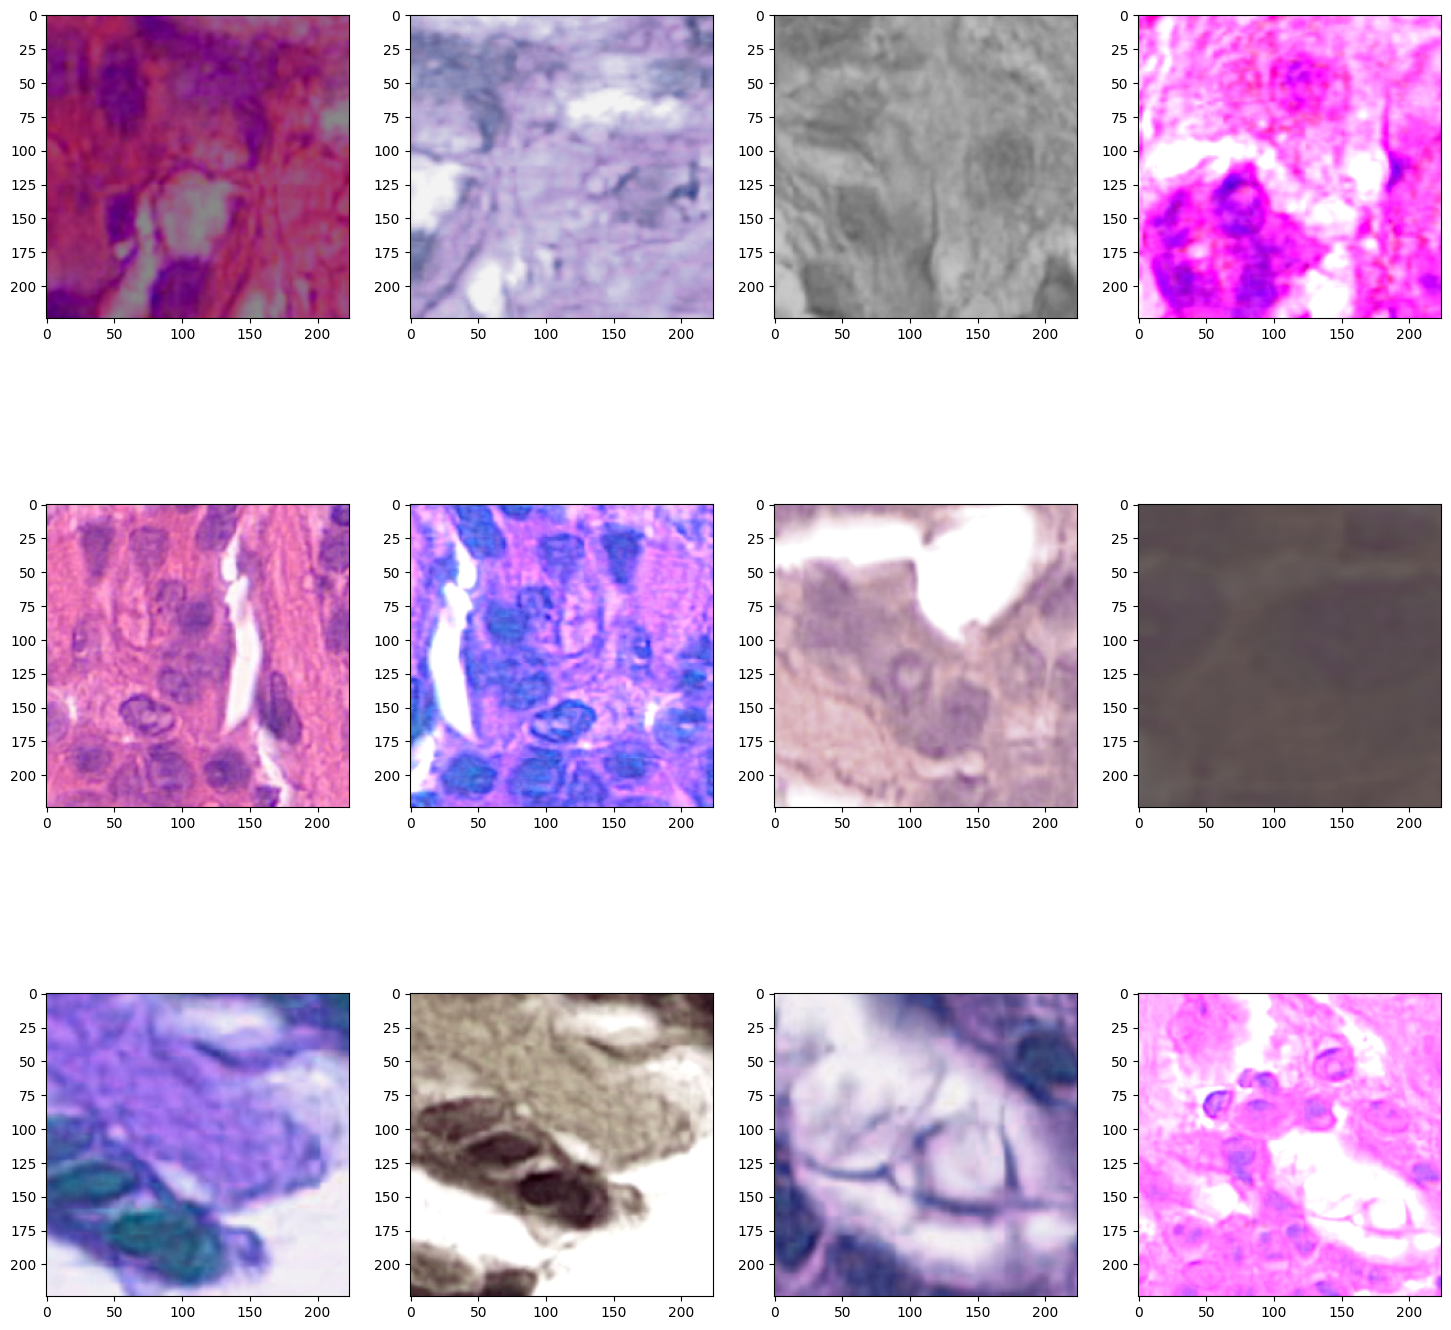

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,18))
cnt = 1
for i in range(6):
    plt.subplot(3,4,cnt)
    plt.imshow(torchvision.transforms.ToPILImage()(train_dataset[i][0][0]))
    cnt+=1
    
    plt.subplot(3,4,cnt)
    plt.imshow(torchvision.transforms.ToPILImage()(train_dataset[i][0][1]))
    cnt+=1
    
plt.show()

In [16]:
resnet = "resnet50"
encoder = get_resnet(resnet, pretrained=False)
n_features = encoder.fc.in_features  # get dimensions of fc layer

projection_dim = 64
model = SimCLR(encoder, projection_dim, n_features)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

optimizer, scheduler = load_optimizer("Adam", model)

/home/ai/anaconda3/envs/main/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ai/anaconda3/envs/main/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [17]:
criterion = NT_Xent(batch_size, temperature, world_size=1)

In [18]:
print(model_path)
print(resnet)
print(batch_size)
print(len(train_dataset))

../save1/NoD1500_R50_B64_Adam
resnet50
64
4500


In [19]:
global_step = 0
current_epoch = 0
start_epoch = 0
for epoch in range(start_epoch, epochs):
    lr = optimizer.param_groups[0]["lr"]
    loss_epoch = train(global_step, train_loader, model, criterion, optimizer, writer)
    
    if scheduler:
        scheduler.step()
        
    if epoch % 50 == 0:
        save_model(model_path, current_epoch, model, optimizer)
        
    writer.add_scalar("Loss/train", loss_epoch / len(train_loader), epoch)
    writer.add_scalar("Misc/learning_rate", lr, epoch)
    print(
        f"Epoch [{epoch}/{epochs}]\t Loss: {loss_epoch / len(train_loader)}\t lr: {round(lr, 5)}"
    )
    current_epoch += 1
    
save_model(model_path, current_epoch, model, optimizer)

Step [0/70]	 Loss: 4.852560043334961
Step [50/70]	 Loss: 4.7705559730529785
Epoch [0/1000]	 Loss: 4.819886493682861	 lr: 0.0003
Step [0/70]	 Loss: 4.780543327331543
Step [50/70]	 Loss: 4.795919418334961
Epoch [1/1000]	 Loss: 4.805774518421718	 lr: 0.0003
Step [0/70]	 Loss: 4.792666912078857
Step [50/70]	 Loss: 4.791634559631348
Epoch [2/1000]	 Loss: 4.804061467306955	 lr: 0.0003
Step [0/70]	 Loss: 4.841839790344238
Step [50/70]	 Loss: 4.946761131286621
Epoch [3/1000]	 Loss: 4.801574550356183	 lr: 0.0003
Step [0/70]	 Loss: 4.808913230895996
Step [50/70]	 Loss: 4.765124320983887
Epoch [4/1000]	 Loss: 4.791856404713222	 lr: 0.0003
Step [0/70]	 Loss: 4.819702625274658
Step [50/70]	 Loss: 4.860049247741699
Epoch [5/1000]	 Loss: 4.785847364153181	 lr: 0.0003
Step [0/70]	 Loss: 4.795952320098877
Step [50/70]	 Loss: 4.762388229370117
Epoch [6/1000]	 Loss: 4.786680289677212	 lr: 0.0003
Step [0/70]	 Loss: 4.775664329528809
Step [50/70]	 Loss: 4.760063648223877
Epoch [7/1000]	 Loss: 4.78198584829

Step [50/70]	 Loss: 4.1783766746521
Epoch [64/1000]	 Loss: 4.037291049957275	 lr: 0.0003
Step [0/70]	 Loss: 4.073058605194092
Step [50/70]	 Loss: 4.048885345458984
Epoch [65/1000]	 Loss: 4.038929530552456	 lr: 0.0003
Step [0/70]	 Loss: 4.021326541900635
Step [50/70]	 Loss: 4.078188419342041
Epoch [66/1000]	 Loss: 4.010383095060076	 lr: 0.0003
Step [0/70]	 Loss: 3.934600830078125
Step [50/70]	 Loss: 4.004555702209473
Epoch [67/1000]	 Loss: 4.000326817376273	 lr: 0.0003
Step [0/70]	 Loss: 3.9275903701782227
Step [50/70]	 Loss: 4.036123752593994
Epoch [68/1000]	 Loss: 4.006243814740862	 lr: 0.0003
Step [0/70]	 Loss: 3.927781105041504
Step [50/70]	 Loss: 3.9581897258758545
Epoch [69/1000]	 Loss: 3.9983434779303413	 lr: 0.0003
Step [0/70]	 Loss: 3.960047721862793
Step [50/70]	 Loss: 4.055505752563477
Epoch [70/1000]	 Loss: 3.9907828739711215	 lr: 0.0003
Step [0/70]	 Loss: 4.033535003662109
Step [50/70]	 Loss: 3.768005847930908
Epoch [71/1000]	 Loss: 3.972735844339643	 lr: 0.0003
Step [0/70]

Epoch [127/1000]	 Loss: 3.6979101862226216	 lr: 0.0003
Step [0/70]	 Loss: 3.642148971557617
Step [50/70]	 Loss: 3.676780939102173
Epoch [128/1000]	 Loss: 3.6861044134412495	 lr: 0.0003
Step [0/70]	 Loss: 3.6642937660217285
Step [50/70]	 Loss: 3.632235050201416
Epoch [129/1000]	 Loss: 3.693031961577279	 lr: 0.0003
Step [0/70]	 Loss: 3.7434606552124023
Step [50/70]	 Loss: 3.6034772396087646
Epoch [130/1000]	 Loss: 3.6907552344458443	 lr: 0.0003
Step [0/70]	 Loss: 3.6570308208465576
Step [50/70]	 Loss: 3.7466442584991455
Epoch [131/1000]	 Loss: 3.6842989001955306	 lr: 0.0003
Step [0/70]	 Loss: 3.610710859298706
Step [50/70]	 Loss: 3.6528713703155518
Epoch [132/1000]	 Loss: 3.695097133091518	 lr: 0.0003
Step [0/70]	 Loss: 3.562509775161743
Step [50/70]	 Loss: 3.6964309215545654
Epoch [133/1000]	 Loss: 3.679016447067261	 lr: 0.0003
Step [0/70]	 Loss: 3.6536741256713867
Step [50/70]	 Loss: 3.7664520740509033
Epoch [134/1000]	 Loss: 3.6805951595306396	 lr: 0.0003
Step [0/70]	 Loss: 3.72845697

Step [50/70]	 Loss: 3.589827060699463
Epoch [190/1000]	 Loss: 3.568891978263855	 lr: 0.0003
Step [0/70]	 Loss: 3.562703847885132
Step [50/70]	 Loss: 3.510293483734131
Epoch [191/1000]	 Loss: 3.5737345150538853	 lr: 0.0003
Step [0/70]	 Loss: 3.624751091003418
Step [50/70]	 Loss: 3.554913282394409
Epoch [192/1000]	 Loss: 3.5746736185891286	 lr: 0.0003
Step [0/70]	 Loss: 3.606081962585449
Step [50/70]	 Loss: 3.5503134727478027
Epoch [193/1000]	 Loss: 3.5755461147853307	 lr: 0.0003
Step [0/70]	 Loss: 3.5746910572052
Step [50/70]	 Loss: 3.5850563049316406
Epoch [194/1000]	 Loss: 3.5686511618750436	 lr: 0.0003
Step [0/70]	 Loss: 3.593944787979126
Step [50/70]	 Loss: 3.6635689735412598
Epoch [195/1000]	 Loss: 3.566058645929609	 lr: 0.0003
Step [0/70]	 Loss: 3.4580817222595215
Step [50/70]	 Loss: 3.628403425216675
Epoch [196/1000]	 Loss: 3.566259207044329	 lr: 0.0003
Step [0/70]	 Loss: 3.4776835441589355
Step [50/70]	 Loss: 3.5575478076934814
Epoch [197/1000]	 Loss: 3.5675638743809293	 lr: 0.0

Step [50/70]	 Loss: 3.5139918327331543
Epoch [253/1000]	 Loss: 3.489165152822222	 lr: 0.0003
Step [0/70]	 Loss: 3.4523682594299316
Step [50/70]	 Loss: 3.4598052501678467
Epoch [254/1000]	 Loss: 3.4877047879355296	 lr: 0.0003
Step [0/70]	 Loss: 3.5017826557159424
Step [50/70]	 Loss: 3.4695568084716797
Epoch [255/1000]	 Loss: 3.4854183060782296	 lr: 0.0003
Step [0/70]	 Loss: 3.4086976051330566
Step [50/70]	 Loss: 3.4515647888183594
Epoch [256/1000]	 Loss: 3.4791092021124705	 lr: 0.0003
Step [0/70]	 Loss: 3.4488909244537354
Step [50/70]	 Loss: 3.4941346645355225
Epoch [257/1000]	 Loss: 3.49439514705113	 lr: 0.0003
Step [0/70]	 Loss: 3.4881904125213623
Step [50/70]	 Loss: 3.4838738441467285
Epoch [258/1000]	 Loss: 3.4764678716659545	 lr: 0.0003
Step [0/70]	 Loss: 3.5015203952789307
Step [50/70]	 Loss: 3.5873959064483643
Epoch [259/1000]	 Loss: 3.487195328303746	 lr: 0.0003
Step [0/70]	 Loss: 3.489812135696411
Step [50/70]	 Loss: 3.5868139266967773
Epoch [260/1000]	 Loss: 3.4860426698412215

Step [0/70]	 Loss: 3.47582745552063
Step [50/70]	 Loss: 3.4391238689422607
Epoch [316/1000]	 Loss: 3.461260632106236	 lr: 0.0003
Step [0/70]	 Loss: 3.4500012397766113
Step [50/70]	 Loss: 3.38676118850708
Epoch [317/1000]	 Loss: 3.44699752671378	 lr: 0.0003
Step [0/70]	 Loss: 3.438591718673706
Step [50/70]	 Loss: 3.5199286937713623
Epoch [318/1000]	 Loss: 3.432472280093602	 lr: 0.0003
Step [0/70]	 Loss: 3.369063138961792
Step [50/70]	 Loss: 3.488614320755005
Epoch [319/1000]	 Loss: 3.446292209625244	 lr: 0.0003
Step [0/70]	 Loss: 3.4397056102752686
Step [50/70]	 Loss: 3.4415042400360107
Epoch [320/1000]	 Loss: 3.4413990088871547	 lr: 0.0003
Step [0/70]	 Loss: 3.317378282546997
Step [50/70]	 Loss: 3.523338794708252
Epoch [321/1000]	 Loss: 3.437871483394078	 lr: 0.0003
Step [0/70]	 Loss: 3.350494146347046
Step [50/70]	 Loss: 3.459632396697998
Epoch [322/1000]	 Loss: 3.438920746530805	 lr: 0.0003
Step [0/70]	 Loss: 3.426906108856201
Step [50/70]	 Loss: 3.371647596359253
Epoch [323/1000]	 L

Step [0/70]	 Loss: 3.4173011779785156
Step [50/70]	 Loss: 3.3671681880950928
Epoch [379/1000]	 Loss: 3.409086516925267	 lr: 0.0003
Step [0/70]	 Loss: 3.334622621536255
Step [50/70]	 Loss: 3.348066568374634
Epoch [380/1000]	 Loss: 3.4112388576780046	 lr: 0.0003
Step [0/70]	 Loss: 3.391073703765869
Step [50/70]	 Loss: 3.3107261657714844
Epoch [381/1000]	 Loss: 3.4053951127188546	 lr: 0.0003
Step [0/70]	 Loss: 3.413667678833008
Step [50/70]	 Loss: 3.386432409286499
Epoch [382/1000]	 Loss: 3.4090502534593856	 lr: 0.0003
Step [0/70]	 Loss: 3.417001247406006
Step [50/70]	 Loss: 3.4344089031219482
Epoch [383/1000]	 Loss: 3.4108377729143413	 lr: 0.0003
Step [0/70]	 Loss: 3.440420150756836
Step [50/70]	 Loss: 3.4170191287994385
Epoch [384/1000]	 Loss: 3.421924298150199	 lr: 0.0003
Step [0/70]	 Loss: 3.43007230758667
Step [50/70]	 Loss: 3.3882739543914795
Epoch [385/1000]	 Loss: 3.409396948133196	 lr: 0.0003
Step [0/70]	 Loss: 3.3588225841522217
Step [50/70]	 Loss: 3.442229986190796
Epoch [386/1

Step [0/70]	 Loss: 3.4959969520568848
Step [50/70]	 Loss: 3.34941029548645
Epoch [442/1000]	 Loss: 3.397582565035139	 lr: 0.0003
Step [0/70]	 Loss: 3.4742934703826904
Step [50/70]	 Loss: 3.4590511322021484
Epoch [443/1000]	 Loss: 3.3937931333269393	 lr: 0.0003
Step [0/70]	 Loss: 3.482612371444702
Step [50/70]	 Loss: 3.441154956817627
Epoch [444/1000]	 Loss: 3.3884597199303763	 lr: 0.0003
Step [0/70]	 Loss: 3.507950782775879
Step [50/70]	 Loss: 3.3881289958953857
Epoch [445/1000]	 Loss: 3.400463134901864	 lr: 0.0003
Step [0/70]	 Loss: 3.235318183898926
Step [50/70]	 Loss: 3.395820379257202
Epoch [446/1000]	 Loss: 3.386572980880737	 lr: 0.0003
Step [0/70]	 Loss: 3.342388153076172
Step [50/70]	 Loss: 3.3318610191345215
Epoch [447/1000]	 Loss: 3.383349016734532	 lr: 0.0003
Step [0/70]	 Loss: 3.406071901321411
Step [50/70]	 Loss: 3.2863168716430664
Epoch [448/1000]	 Loss: 3.392491136278425	 lr: 0.0003
Step [0/70]	 Loss: 3.4096336364746094
Step [50/70]	 Loss: 3.314394950866699
Epoch [449/100

Step [0/70]	 Loss: 3.380568742752075
Step [50/70]	 Loss: 3.298196315765381
Epoch [505/1000]	 Loss: 3.3602992023740494	 lr: 0.0003
Step [0/70]	 Loss: 3.3318684101104736
Step [50/70]	 Loss: 3.4435133934020996
Epoch [506/1000]	 Loss: 3.373479093824114	 lr: 0.0003
Step [0/70]	 Loss: 3.375009536743164
Step [50/70]	 Loss: 3.4633965492248535
Epoch [507/1000]	 Loss: 3.384069187300546	 lr: 0.0003
Step [0/70]	 Loss: 3.3955130577087402
Step [50/70]	 Loss: 3.348987579345703
Epoch [508/1000]	 Loss: 3.3599355936050417	 lr: 0.0003
Step [0/70]	 Loss: 3.389460563659668
Step [50/70]	 Loss: 3.299997329711914
Epoch [509/1000]	 Loss: 3.3533279691423687	 lr: 0.0003
Step [0/70]	 Loss: 3.448704481124878
Step [50/70]	 Loss: 3.317049264907837
Epoch [510/1000]	 Loss: 3.3707904066358294	 lr: 0.0003
Step [0/70]	 Loss: 3.2730419635772705
Step [50/70]	 Loss: 3.371934175491333
Epoch [511/1000]	 Loss: 3.369837430545262	 lr: 0.0003
Step [0/70]	 Loss: 3.3635151386260986
Step [50/70]	 Loss: 3.392571449279785
Epoch [512/1

Step [0/70]	 Loss: 3.439260244369507
Step [50/70]	 Loss: 3.3306658267974854
Epoch [568/1000]	 Loss: 3.356784244946071	 lr: 0.0003
Step [0/70]	 Loss: 3.3171401023864746
Step [50/70]	 Loss: 3.2862846851348877
Epoch [569/1000]	 Loss: 3.345386702673776	 lr: 0.0003
Step [0/70]	 Loss: 3.332937240600586
Step [50/70]	 Loss: 3.278855800628662
Epoch [570/1000]	 Loss: 3.356953140667507	 lr: 0.0003
Step [0/70]	 Loss: 3.4698269367218018
Step [50/70]	 Loss: 3.4073188304901123
Epoch [571/1000]	 Loss: 3.3472726481301445	 lr: 0.0003
Step [0/70]	 Loss: 3.340390682220459
Step [50/70]	 Loss: 3.2829666137695312
Epoch [572/1000]	 Loss: 3.3380658899034774	 lr: 0.0003
Step [0/70]	 Loss: 3.276261329650879
Step [50/70]	 Loss: 3.3790206909179688
Epoch [573/1000]	 Loss: 3.3433028766087123	 lr: 0.0003
Step [0/70]	 Loss: 3.4604246616363525
Step [50/70]	 Loss: 3.3598520755767822
Epoch [574/1000]	 Loss: 3.3515541281018937	 lr: 0.0003
Step [0/70]	 Loss: 3.3570992946624756
Step [50/70]	 Loss: 3.3234143257141113
Epoch [

Step [0/70]	 Loss: 3.2661497592926025
Step [50/70]	 Loss: 3.3645541667938232
Epoch [631/1000]	 Loss: 3.3403969969068257	 lr: 0.0003
Step [0/70]	 Loss: 3.328794479370117
Step [50/70]	 Loss: 3.401923894882202
Epoch [632/1000]	 Loss: 3.340043640136719	 lr: 0.0003
Step [0/70]	 Loss: 3.3758256435394287
Step [50/70]	 Loss: 3.3997955322265625
Epoch [633/1000]	 Loss: 3.334350783484323	 lr: 0.0003
Step [0/70]	 Loss: 3.312659740447998
Step [50/70]	 Loss: 3.3836498260498047
Epoch [634/1000]	 Loss: 3.333386424609593	 lr: 0.0003
Step [0/70]	 Loss: 3.3012731075286865
Step [50/70]	 Loss: 3.3189423084259033
Epoch [635/1000]	 Loss: 3.3463711840765815	 lr: 0.0003
Step [0/70]	 Loss: 3.355192184448242
Step [50/70]	 Loss: 3.30041766166687
Epoch [636/1000]	 Loss: 3.3363973787852697	 lr: 0.0003
Step [0/70]	 Loss: 3.317595958709717
Step [50/70]	 Loss: 3.3408451080322266
Epoch [637/1000]	 Loss: 3.3400530167988367	 lr: 0.0003
Step [0/70]	 Loss: 3.3716063499450684
Step [50/70]	 Loss: 3.2924814224243164
Epoch [63

Step [0/70]	 Loss: 3.2758960723876953
Step [50/70]	 Loss: 3.3189241886138916
Epoch [694/1000]	 Loss: 3.3192116737365724	 lr: 0.0003
Step [0/70]	 Loss: 3.338054656982422
Step [50/70]	 Loss: 3.363844633102417
Epoch [695/1000]	 Loss: 3.3187037229537966	 lr: 0.0003
Step [0/70]	 Loss: 3.2653872966766357
Step [50/70]	 Loss: 3.3025360107421875
Epoch [696/1000]	 Loss: 3.3319476400102888	 lr: 0.0003
Step [0/70]	 Loss: 3.2814853191375732
Step [50/70]	 Loss: 3.379976749420166
Epoch [697/1000]	 Loss: 3.3240728752953665	 lr: 0.0003
Step [0/70]	 Loss: 3.464233636856079
Step [50/70]	 Loss: 3.3299343585968018
Epoch [698/1000]	 Loss: 3.3195253099714006	 lr: 0.0003
Step [0/70]	 Loss: 3.2727296352386475
Step [50/70]	 Loss: 3.330217123031616
Epoch [699/1000]	 Loss: 3.321031774793352	 lr: 0.0003
Step [0/70]	 Loss: 3.350839138031006
Step [50/70]	 Loss: 3.2806241512298584
Epoch [700/1000]	 Loss: 3.321885388238089	 lr: 0.0003
Step [0/70]	 Loss: 3.294341802597046
Step [50/70]	 Loss: 3.290674924850464
Epoch [70

Step [0/70]	 Loss: 3.3847484588623047
Step [50/70]	 Loss: 3.301915168762207
Epoch [757/1000]	 Loss: 3.318258718081883	 lr: 0.0003
Step [0/70]	 Loss: 3.404953956604004
Step [50/70]	 Loss: 3.357724905014038
Epoch [758/1000]	 Loss: 3.3125439167022703	 lr: 0.0003
Step [0/70]	 Loss: 3.325190782546997
Step [50/70]	 Loss: 3.2342848777770996
Epoch [759/1000]	 Loss: 3.3278949056352887	 lr: 0.0003
Step [0/70]	 Loss: 3.3181400299072266
Step [50/70]	 Loss: 3.300265312194824
Epoch [760/1000]	 Loss: 3.318456438609532	 lr: 0.0003
Step [0/70]	 Loss: 3.3424899578094482
Step [50/70]	 Loss: 3.319148540496826
Epoch [761/1000]	 Loss: 3.3161235979625157	 lr: 0.0003
Step [0/70]	 Loss: 3.248599052429199
Step [50/70]	 Loss: 3.372868299484253
Epoch [762/1000]	 Loss: 3.31030170576913	 lr: 0.0003
Step [0/70]	 Loss: 3.3430659770965576
Step [50/70]	 Loss: 3.2565252780914307
Epoch [763/1000]	 Loss: 3.3076968158994404	 lr: 0.0003
Step [0/70]	 Loss: 3.4226293563842773
Step [50/70]	 Loss: 3.2890284061431885
Epoch [764/

Step [0/70]	 Loss: 3.3330612182617188
Step [50/70]	 Loss: 3.2951149940490723
Epoch [820/1000]	 Loss: 3.29901613507952	 lr: 0.0003
Step [0/70]	 Loss: 3.2836391925811768
Step [50/70]	 Loss: 3.2652952671051025
Epoch [821/1000]	 Loss: 3.2996008157730103	 lr: 0.0003
Step [0/70]	 Loss: 3.240377902984619
Step [50/70]	 Loss: 3.30204439163208
Epoch [822/1000]	 Loss: 3.3066085236413136	 lr: 0.0003
Step [0/70]	 Loss: 3.2196261882781982
Step [50/70]	 Loss: 3.2725796699523926
Epoch [823/1000]	 Loss: 3.3014288697923933	 lr: 0.0003
Step [0/70]	 Loss: 3.2679953575134277
Step [50/70]	 Loss: 3.3813636302948
Epoch [824/1000]	 Loss: 3.305850155012948	 lr: 0.0003
Step [0/70]	 Loss: 3.2128679752349854
Step [50/70]	 Loss: 3.2649948596954346
Epoch [825/1000]	 Loss: 3.296610491616385	 lr: 0.0003
Step [0/70]	 Loss: 3.3373355865478516
Step [50/70]	 Loss: 3.2066290378570557
Epoch [826/1000]	 Loss: 3.2917485850197927	 lr: 0.0003
Step [0/70]	 Loss: 3.3274407386779785
Step [50/70]	 Loss: 3.2469723224639893
Epoch [82

Step [0/70]	 Loss: 3.2221992015838623
Step [50/70]	 Loss: 3.258779525756836
Epoch [883/1000]	 Loss: 3.280265842165266	 lr: 0.0003
Step [0/70]	 Loss: 3.2803268432617188
Step [50/70]	 Loss: 3.2940871715545654
Epoch [884/1000]	 Loss: 3.2959109919411795	 lr: 0.0003
Step [0/70]	 Loss: 3.349698066711426
Step [50/70]	 Loss: 3.271430015563965
Epoch [885/1000]	 Loss: 3.2862139327185496	 lr: 0.0003
Step [0/70]	 Loss: 3.3931663036346436
Step [50/70]	 Loss: 3.311621904373169
Epoch [886/1000]	 Loss: 3.282608379636492	 lr: 0.0003
Step [0/70]	 Loss: 3.268531084060669
Step [50/70]	 Loss: 3.3135619163513184
Epoch [887/1000]	 Loss: 3.288386416435242	 lr: 0.0003
Step [0/70]	 Loss: 3.2684340476989746
Step [50/70]	 Loss: 3.276109457015991
Epoch [888/1000]	 Loss: 3.2770136765071323	 lr: 0.0003
Step [0/70]	 Loss: 3.2948925495147705
Step [50/70]	 Loss: 3.252544403076172
Epoch [889/1000]	 Loss: 3.29375969682421	 lr: 0.0003
Step [0/70]	 Loss: 3.3474557399749756
Step [50/70]	 Loss: 3.3410298824310303
Epoch [890/

Step [0/70]	 Loss: 3.1933417320251465
Step [50/70]	 Loss: 3.284100294113159
Epoch [946/1000]	 Loss: 3.2787765332630703	 lr: 0.0003
Step [0/70]	 Loss: 3.2351648807525635
Step [50/70]	 Loss: 3.2619497776031494
Epoch [947/1000]	 Loss: 3.279814798491342	 lr: 0.0003
Step [0/70]	 Loss: 3.290512800216675
Step [50/70]	 Loss: 3.24133038520813
Epoch [948/1000]	 Loss: 3.282804134913853	 lr: 0.0003
Step [0/70]	 Loss: 3.3077826499938965
Step [50/70]	 Loss: 3.4018099308013916
Epoch [949/1000]	 Loss: 3.27499931539808	 lr: 0.0003
Step [0/70]	 Loss: 3.2619516849517822
Step [50/70]	 Loss: 3.286344528198242
Epoch [950/1000]	 Loss: 3.2797286680766513	 lr: 0.0003
Step [0/70]	 Loss: 3.231342315673828
Step [50/70]	 Loss: 3.253911018371582
Epoch [951/1000]	 Loss: 3.2914868763514926	 lr: 0.0003
Step [0/70]	 Loss: 3.3423638343811035
Step [50/70]	 Loss: 3.2550063133239746
Epoch [952/1000]	 Loss: 3.2830547843660627	 lr: 0.0003
Step [0/70]	 Loss: 3.176983594894409
Step [50/70]	 Loss: 3.227846384048462
Epoch [953/1

In [20]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.17.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
